# 📰 News Recommendation System Part 1 - Data Preprocessing & Analysis  

## 📘 Project Introduction
This project explores user behavior prediction in a news recommendation scenario. The goal is to build a model that can predict a user's future click behavior based on their historical browsing and clicking behavior data, specifically the last news article they clicked on.

The setting is inspired by a real-world news app, where delivering timely, relevant content is essential for user engagement. This project aims to simulate a practical recommender system, combining business intuition with machine learning techniques to address a realistic problem in the content recommendation space.

## 📊 Data Overview
The dataset contains user interaction data from a large-scale news platform, including:
- 300,000 users
- ~3 million clicks
- 360,000+ unique news articles; each news article is represented by a pre-trained embedding vector, capturing semantic relationships between articles.

We extracted click log data from 200,000 users as the training set, 50,000 users as test set A, and 50,000 users as test set B.

## 📄 Data Tables

- train_click_log.csv: Training set user click logs
- testA_click_log.csv: Test set user click logs
- articles.csv: News article information data table
- articles_emb.csv: Embedding vector representation of news articles

|        **Field**        |         **Description**          |
| :---------------------: | :------------------------------: |
|         user_id         |              User ID             |
|    click_article_id     |            Clicked article ID    |
|     click_timestamp     |            Click timestamp        |
|    click_environment    |             Click environment     |
|    click_deviceGroup    |            Click device group     |
|        click_os         |           Click operating system  |
|      click_country      |             Click city            |
|      click_region       |             Click region          |
|   click_referrer_type   |           Click source type       |
|       article_id        | Article ID, corresponding to click_article_id |
|       category_id       |            Article type ID        |
|      created_at_ts      |          Article creation timestamp |
|       words_count       |             Article word count     |
| emb_1,emb_2,...,emb_249 |      Article embedding vector representation |

## 📏 Evaluation Metrics
The final recommendation for each user will include five recommended articles, sorted by click probability.

For example, for user1, our recommendation would be:
> user1, article1, article2, article3, article4, article5.

There is only one correct answer for each user's last clicked article, so we check if any of the recommended five articles match the actual answer. We will use **mean reciprocal rank** as the evaluation metric. The formula is as follows:
$$
score(user) = \sum_{k=1}^5 \frac{s(user, k)}{k}
$$

If article1 is the actual article clicked by the user, then s(user1, 1) = 1, and s(user1, 2-4) are all 0. If article2 is the article clicked by the user, then s(user, 2) = 1/2, and s(user, 1, 3, 4, 5) are all 0. Thus, score(user) = the reciprocal of the rank at which the match occurs. If there are no matches, score(user1) = 0. This is reasonable because we want hits to be as high-ranking as possible, which yields a higher score.

## 💡 Project Understanding
The goal of this project is to **predict the last news article a user clicked, based on their historical browsing data**. Unlike traditional structured prediction problems, this is more aligned with real-world recommendation systems, using raw user click logs rather than neatly labeled data.

To approach this, I framed the task as a **supervised learning** problem by transforming user-article interactions into "features + labels" training data. The core idea is to predict the likelihood of a user clicking a given article, turning this into a click-through rate (CTR) prediction task. This reframing allows for the use of **classification models**—starting with simple baselines like logistic regression and moving toward deep learning approaches.

Now, we have converted this problem into a classification problem, where the classification label is whether the user will click on a particular article. The features of the classification problem will include the user and the article. We need to train a classification model to predict the probability of a particular user clicking on a specific article. This raises several additional questions:
- How to create training and testing datasets?
- What specific features can we leverage?
- What models can we attempt?
- With 360,000 articles and over 200,000 users, what strategies do we have to reduce the problem's scale? How do we make the final predictions?

**For the first part, we will preprocess and analyze the news-user interactive data.**

## 📈 Data Preprocessing & Data Analysis

**Step 1: User Attribute Analysis**

- **User Count Distribution**: Analyze the number of users included in the training and testing sets through visualization to understand the overall scale of user data.
- **User City Distribution Patterns**: Analyze the geographical distribution of users through city-level data visualization, exploring whether there are regional concentrations or dispersions.
- **Average Click Count per User**: Calculate the average article click count for each user and present it through charts to understand user activity distribution.
- **Correlation Between Click Source and Article Click Count**: Analyze the relationship between different click sources (e.g., homepage recommendations, search results) and article click counts, determining whether behavioral patterns differ among users from different sources.

**Step 2: User Behavior Analysis**

- **Time Patterns of User Click Behavior**: Analyze users' continuous click behavior through visualizations of timestamp data, checking if reading habits or continuous clicking patterns can be identified from click intervals.
- **Similarity Between Articles**: Analyze whether there is content similarity when users read different articles, using the user's click sequence for article similarity analysis and visualization.
- **Correlation Between Click Source and Article Type**: Analyze the relationship between the source of user clicks (e.g., recommendations, searches) and article types (e.g., news, entertainment, technology) to explore whether there are differences in user preferences across sources.

**Step 3: Article Content Analysis**

- **Correlation Between Article Length and Click Count**: Analyze the relationship between article length and click count to determine whether article length impacts click volume, with visualizations of the correlation.
- **Clustering and Dimensionality Reduction Visualization of Article Embedding Vectors**: Use article embedding vectors for similarity calculations, attempt to cluster articles, and visualize clustering results using dimensionality reduction techniques (e.g., PCA or t-SNE) to intuitively display content similarities between articles.
- **Correlation Between Article Creation Time and Click Time**: Analyze the relationship between article creation time and user click time, determining if specific time periods lead to higher article clicks and visualizing the relationship between time intervals and click behavior.

## Import Packages

In [ ]:
import pandas as pd  # Import the pandas library for data processing and analysis
import numpy as np  # Import the NumPy library for numerical calculations

import matplotlib as mpl
import matplotlib.pyplot as plt  # Import the matplotlib library for data visualization
import seaborn as sns  # Import the seaborn library for more aesthetically pleasing data visualization

import os  # Import the os module for operating system-related functions
import gc  # Import the gc module for garbage collection
import re  # Import the re module for regular expression operations
import warnings  # Import the warnings module to ignore warning messages
import sys  # Import the sys module to access system-related functions
import nltk # Import Natural Language Toolkit
import networkx as nx # Import NetworkX for graph analysis and manipulation

warnings.filterwarnings("ignore")  # Ignore warning messages
%matplotlib inline

## Read Data

In [ ]:
# If using Google Colab, use this cell to load data
from google.colab import drive

# Connect to Google Drive
drive.mount('/content/drive')

# Define file paths
data_path = '/content/drive/MyDrive/Datasets/news-rec-sys/'
save_path = '/content/drive/MyDrive/Datasets/news-rec-sys/temp_results/'

# train set
train_click = pd.read_csv(data_path + 'train_click_log.csv')
item_df = pd.read_csv(data_path + 'articles.csv')
item_df = item_df.rename(columns={'article_id': 'click_article_id'})  # Rename
item_emb_df = pd.read_csv(data_path + 'articles_emb.csv')

# test set
test_click = pd.read_csv(data_path + 'testA_click_log.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Preprocessing

In [ ]:
train_click.head()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,199999,160417,1507029570190,4,1,17,1,13,1
1,199999,5408,1507029571478,4,1,17,1,13,1
2,199999,50823,1507029601478,4,1,17,1,13,1
3,199998,157770,1507029532200,4,1,17,1,25,5
4,199998,96613,1507029671831,4,1,17,1,25,5


#### Meanings of Each Field in the train_click_log.csv File

1. user_id: Unique identifier for the user
2. click_article_id: Unique identifier for the article clicked by the user
3. click_timestamp: Timestamp when the user clicked the article
4. click_environment: Environment in which the user clicked the article
5. click_deviceGroup: Device group used by the user to click the article
6. click_os: Operating system used by the user when clicking the article
7. click_country: Country where the user was located when clicking the article
8. click_region: Region where the user was located when clicking the article
9. click_referrer_type: Source of the article when the user clicked on it

In [ ]:
# Sort the click timestamps for each user.
train_click['rank'] = train_click.groupby(['user_id'])['click_timestamp'].rank(ascending=False).astype(int)
test_click['rank'] = test_click.groupby(['user_id'])['click_timestamp'].rank(ascending=False).astype(int)

# Count the number of articles clicked by each user and add a new column named "count."
train_click['click_count'] = train_click.groupby(['user_id'])['click_timestamp'].transform('count')
test_click['click_count'] = test_click.groupby(['user_id'])['click_timestamp'].transform('count')

In [ ]:
train_click[train_click['user_id'] == 199999]

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_count
0,199999,160417,1507029570190,4,1,17,1,13,1,11,11
1,199999,5408,1507029571478,4,1,17,1,13,1,10,11
2,199999,50823,1507029601478,4,1,17,1,13,1,9,11
211041,199999,123909,1507226987864,4,1,17,1,13,1,8,11
211042,199999,168623,1507227017864,4,1,17,1,13,1,7,11
660731,199999,161191,1507665351186,4,1,17,1,13,1,6,11
660732,199999,42223,1507665381186,4,1,17,1,13,1,5,11
709171,199999,70214,1507721405411,4,1,17,1,13,1,4,11
709172,199999,156843,1507721435411,4,1,17,1,13,1,3,11
1081894,199999,159019,1508176837088,4,1,17,1,13,1,2,11


## Data Preview
### a. User Click Logs - Training Set

In [ ]:
train_click = train_click.merge(item_df, how='left', on=['click_article_id'])
train_click.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1112623 entries, 0 to 1112622
Data columns (total 14 columns):
 #   Column               Non-Null Count    Dtype
---  ------               --------------    -----
 0   user_id              1112623 non-null  int64
 1   click_article_id     1112623 non-null  int64
 2   click_timestamp      1112623 non-null  int64
 3   click_environment    1112623 non-null  int64
 4   click_deviceGroup    1112623 non-null  int64
 5   click_os             1112623 non-null  int64
 6   click_country        1112623 non-null  int64
 7   click_region         1112623 non-null  int64
 8   click_referrer_type  1112623 non-null  int64
 9   rank                 1112623 non-null  int64
 10  click_count          1112623 non-null  int64
 11  category_id          1112623 non-null  int64
 12  created_at_ts        1112623 non-null  int64
 13  words_count          1112623 non-null  int64
dtypes: int64(14)
memory usage: 118.8 MB


In [ ]:
train_click.describe()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_count,category_id,created_at_ts,words_count
count,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06
mean,1.221198e+05,1.951541e+05,1.507588e+12,3.947786e+00,1.815981e+00,1.301976e+01,1.310776e+00,1.813587e+01,1.910063e+00,7.118518e+00,1.323704e+01,3.056176e+02,1.506598e+12,2.011981e+02
std,5.540349e+04,9.292286e+04,3.363466e+08,3.276715e-01,1.035170e+00,6.967844e+00,1.618264e+00,7.105832e+00,1.220012e+00,1.016095e+01,1.631503e+01,1.155791e+02,8.343066e+09,5.223881e+01
min,0.000000e+00,3.000000e+00,1.507030e+12,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.166573e+12,0.000000e+00
25%,7.934700e+04,1.239090e+05,1.507297e+12,4.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.300000e+01,1.000000e+00,2.000000e+00,4.000000e+00,2.500000e+02,1.507220e+12,1.700000e+02
50%,1.309670e+05,2.038900e+05,1.507596e+12,4.000000e+00,1.000000e+00,1.700000e+01,1.000000e+00,2.100000e+01,2.000000e+00,4.000000e+00,8.000000e+00,3.280000e+02,1.507553e+12,1.970000e+02
75%,1.704010e+05,2.777120e+05,1.507841e+12,4.000000e+00,3.000000e+00,1.700000e+01,1.000000e+00,2.500000e+01,2.000000e+00,8.000000e+00,1.600000e+01,4.100000e+02,1.507756e+12,2.280000e+02
max,1.999990e+05,3.640460e+05,1.510603e+12,4.000000e+00,5.000000e+00,2.000000e+01,1.100000e+01,2.800000e+01,7.000000e+00,2.410000e+02,2.410000e+02,4.600000e+02,1.510666e+12,6.690000e+03


In [ ]:
# The number of users in the training set is 200,000
train_click.user_id.nunique()

200000

In [ ]:
# Each user in the training set clicked on at least two articles.
train_click.groupby(['user_id'])['click_article_id'].count().min()

2

##### A histogram will be created to provide a general view of the basic attribute distribution.

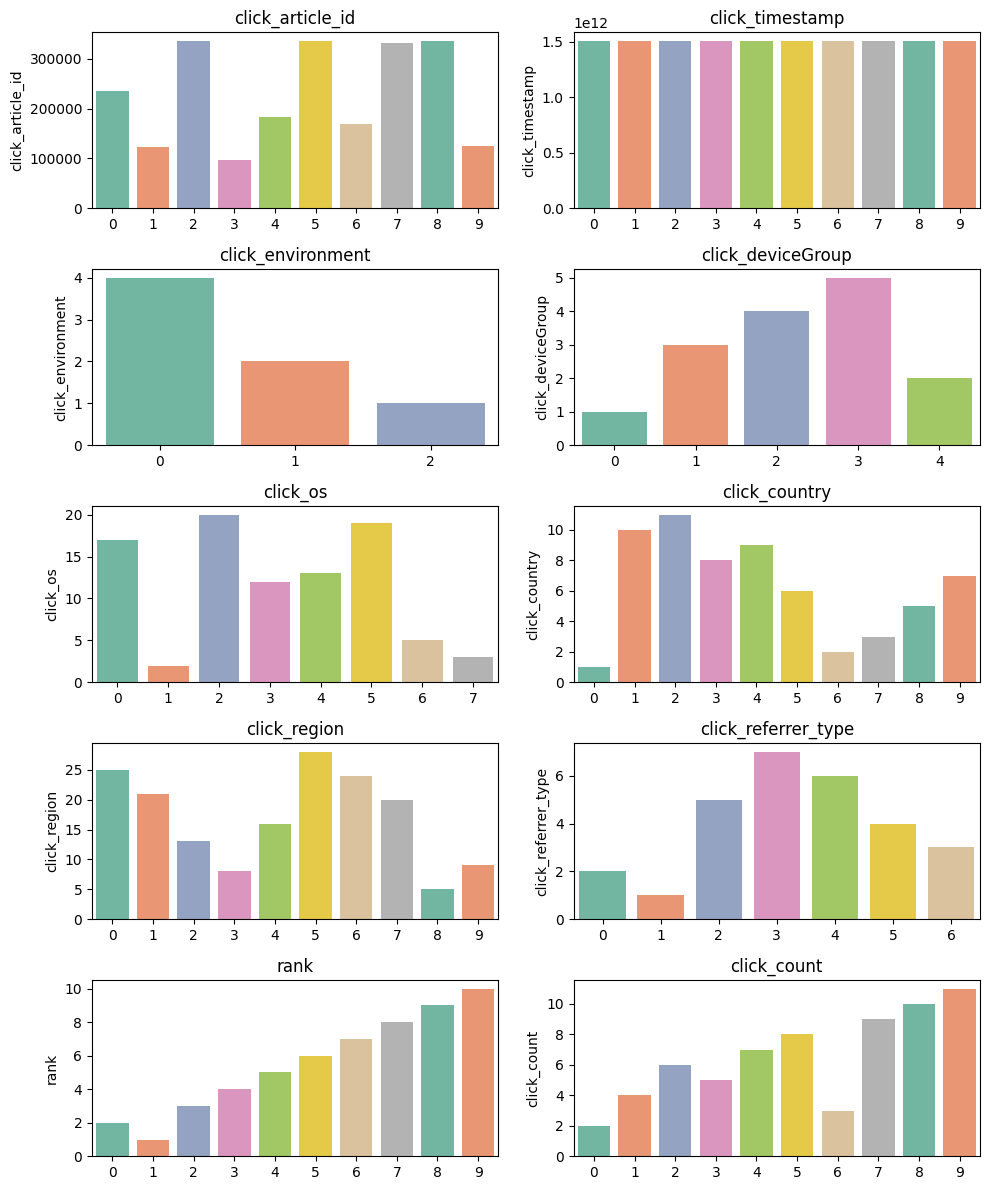

In [ ]:
def plot_bar_chart(data, column, ax):
    """
    Draw a bar chart
    """
    value_counts = data[column].value_counts().reset_index()[:10]
    sns.barplot(x=value_counts.index, y=value_counts[column], ax=ax, palette='Set2')
    for item in ax.get_xticklabels():
        item.set_rotation(0)
    ax.set_title(column)
    ax.set_xlabel('')

# Create a new figure window
fig, axes = plt.subplots(5, 2, figsize=(10, 12))

# Place subplots in a 5x2 grid
for i, column in enumerate(['click_article_id', 'click_timestamp', 'click_environment', 'click_deviceGroup',
                            'click_os', 'click_country', 'click_region', 'click_referrer_type', 'rank', 'click_count']):
    plot_bar_chart(train_click, column, axes[i//2, i%2])

plt.tight_layout()
plt.show()


Note: The click_count histogram here represents the cumulative chart of user click counts for each article.

<Axes: xlabel='click_environment'>

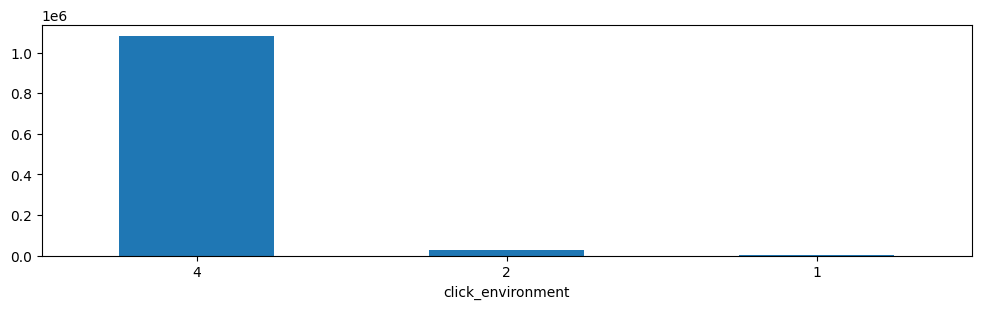

In [ ]:
train_click['click_environment'].value_counts().plot(kind='bar', figsize=(12, 3), rot=0)

From the click environment analysis, Environment4 accounts for the majority at 97.6%, while Environment2 and Environment1 comprises only 2.3% and 0.19%.

In [ ]:
train_click['click_deviceGroup'].value_counts(normalize=True)

,proportion
click_deviceGroup,
1,0.609539
3,0.355518
4,0.034811
5,0.000127
2,0.000005


From the click device group analysis, Device 1 accounts for the majority at 61%, while Device 3 comprises 36%.

### b. User Click Logs - Testing Set

In [ ]:
test_click = test_click.merge(item_df, how='left', on=['click_article_id'])
test_click.head()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_count,category_id,created_at_ts,words_count
0,249999,160974,1506959142820,4,1,17,1,13,2,19,19,281,1506912747000,259
1,249999,160417,1506959172820,4,1,17,1,13,2,18,19,281,1506942089000,173
2,249998,160974,1506959056066,4,1,12,1,13,2,5,5,281,1506912747000,259
3,249998,202557,1506959086066,4,1,12,1,13,2,4,5,327,1506938401000,219
4,249997,183665,1506959088613,4,1,17,1,15,5,7,7,301,1500895686000,256


In [ ]:
test_click.describe()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_count,category_id,created_at_ts,words_count
count,518010.000000,518010.000000,5.180100e+05,518010.000000,518010.000000,518010.000000,518010.000000,518010.000000,518010.000000,518010.000000,518010.000000,518010.000000,5.180100e+05,518010.000000
mean,227342.428169,193803.792550,1.507387e+12,3.947300,1.738285,13.628467,1.348209,18.250250,1.819614,15.521785,30.043586,305.324961,1.506883e+12,210.966331
std,14613.907188,88279.388177,3.706127e+08,0.323916,1.020858,6.625564,1.703524,7.060798,1.082657,33.957702,56.868021,110.411513,5.816668e+09,83.040065
min,200000.000000,137.000000,1.506959e+12,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.265812e+12,0.000000
25%,214926.000000,128551.000000,1.507026e+12,4.000000,1.000000,12.000000,1.000000,13.000000,1.000000,4.000000,10.000000,252.000000,1.506970e+12,176.000000
50%,229109.000000,199197.000000,1.507308e+12,4.000000,1.000000,17.000000,1.000000,21.000000,2.000000,8.000000,19.000000,323.000000,1.507249e+12,199.000000
75%,240182.000000,272143.000000,1.507666e+12,4.000000,3.000000,17.000000,1.000000,25.000000,2.000000,18.000000,35.000000,399.000000,1.507630e+12,232.000000
max,249999.000000,364043.000000,1.508832e+12,4.000000,5.000000,20.000000,11.000000,28.000000,7.000000,938.000000,938.000000,460.000000,1.509949e+12,3082.000000


In [ ]:
set(train_click.user_id) & set(test_click.user_id)

set()

We can see that the users in the training set and the test set are completely different.

The user IDs for the training set range from 0 to 199999, while the user IDs for test set A range from 200000 to 249999.

Therefore, this means that when we train the data, we need to include the test set data as well, which is referred to as the full dataset.

In [ ]:
# The number of users in the test set is 50,000.
test_click['user_id'].nunique()

50000

In [ ]:
# Each user in the test set clicked on at least one articles, different from the training set
test_click.groupby('user_id')['click_article_id'].count().min()

1

### c. News article information data

In [ ]:
# The preview of the news article dataset
pd.concat([item_df.head(), item_df.tail()])

,click_article_id,category_id,created_at_ts,words_count
0,0,0,1513144419000,168
1,1,1,1405341936000,189
2,2,1,1408667706000,250
3,3,1,1408468313000,230
4,4,1,1407071171000,162
364042,364042,460,1434034118000,144
364043,364043,460,1434148472000,463
364044,364044,460,1457974279000,177
364045,364045,460,1515964737000,126
364046,364046,460,1505811330000,479


#### Article Word Count

1. Overall Distribution of Article Lengths

We need to examine whether shorter articles are more prevalent or if longer articles dominate. It's also important to check for any outliers or ranges where word counts are concentrated. If shorter articles are more common, it may indicate that content consumption on the platform tends to favor quick browsing. Conversely, a higher number of longer articles could suggest that users have a certain demand for in-depth reading.

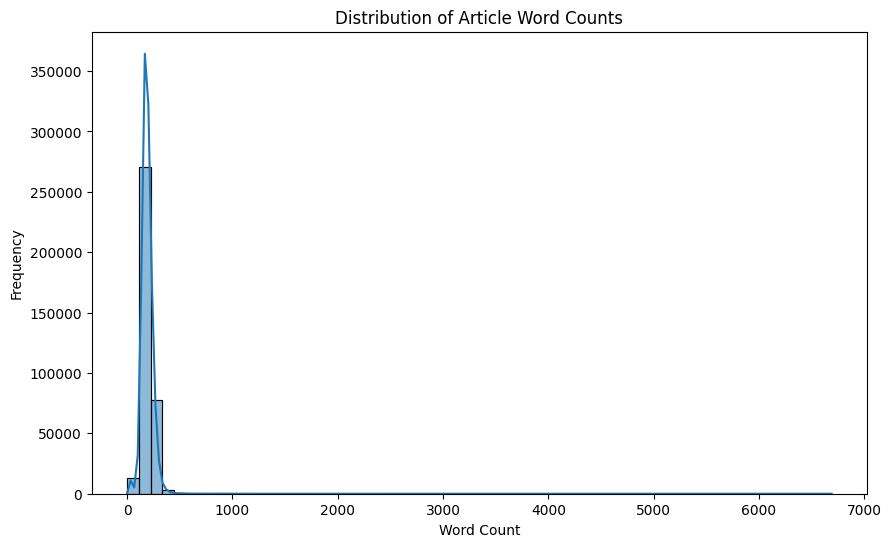

In [ ]:
# Plot word count distribution
plt.figure(figsize=(10, 6))
sns.histplot(item_df['words_count'], bins=60, kde=True)
plt.title('Distribution of Article Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

<Axes: >

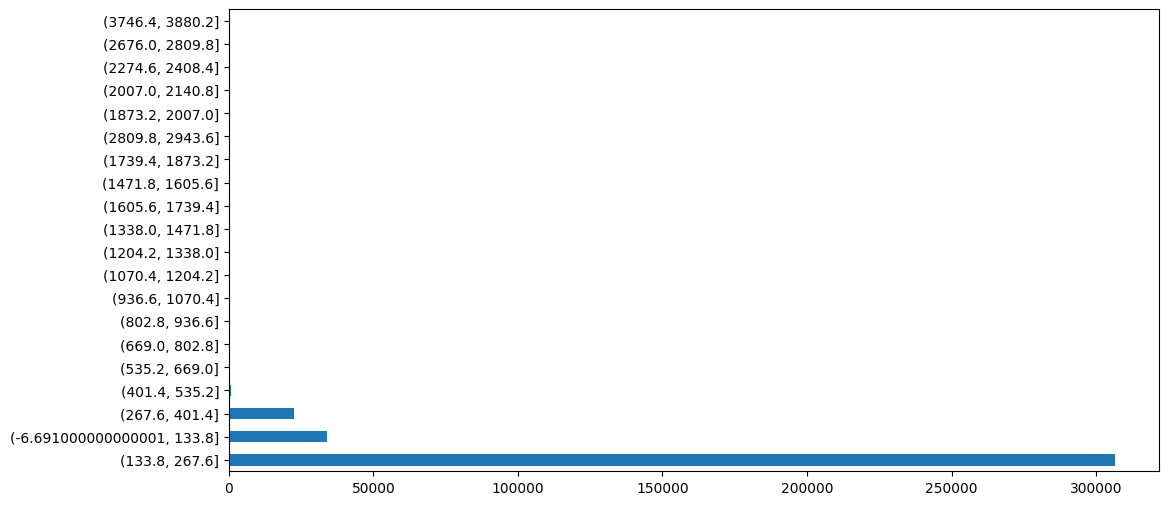

In [ ]:
# Use value_counts for binning instead
item_df['words_count'].value_counts(bins=50)[:20].plot(kind='barh', figsize=(12, 6), rot=0)

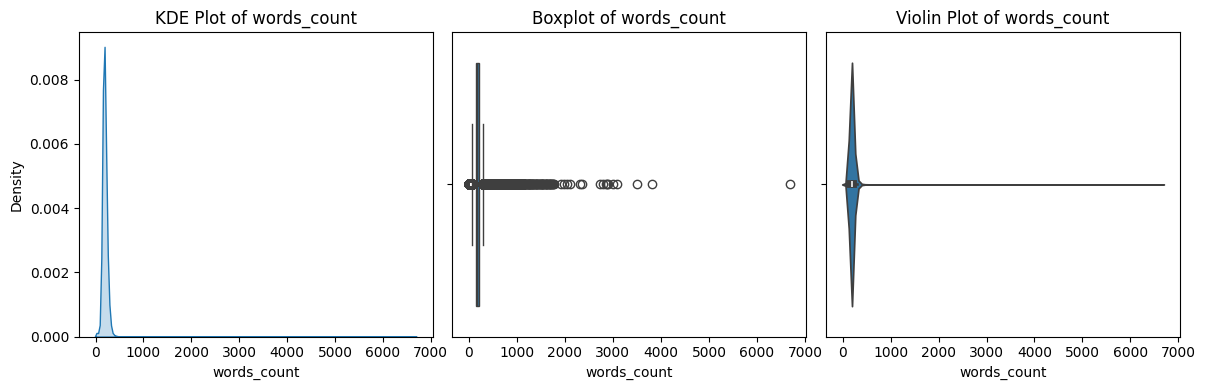

In [ ]:
# More visualizations of word count distribution
def plot_distribution(data, column):
    """
    Draw three types of charts to show data distribution: Kernel Density Estimate (KDE), Boxplot, and Violin Plot.

    Parameters:
    - data: DataFrame containing the data for the distribution plots
    - column: str, the name of the column to be plotted
    """
    plt.figure(figsize=(12, 4))

    # Kernel Density Estimate Plot
    plt.subplot(1, 3, 1)
    sns.kdeplot(data[column], fill=True)
    plt.title(f'KDE Plot of {column}')
    plt.xlabel(column)
    plt.ylabel('Density')

    # Boxplot
    plt.subplot(1, 3, 2)
    sns.boxplot(x=data[column])
    plt.title(f'Boxplot of {column}')
    plt.xlabel(column)

    # Violin Plot
    plt.subplot(1, 3, 3)
    sns.violinplot(x=data[column])
    plt.title(f'Violin Plot of {column}')
    plt.xlabel(column)

    plt.tight_layout()
    plt.show()

# Example usage:
plot_distribution(item_df, 'words_count')

2. The relationship between word count and publication time seeks to determine if there is a trend in article lengths over different time periods. If a change in word count is observed over time, it may indicate a shift in the platform's content strategy or a change in user preferences for shorter or longer articles.

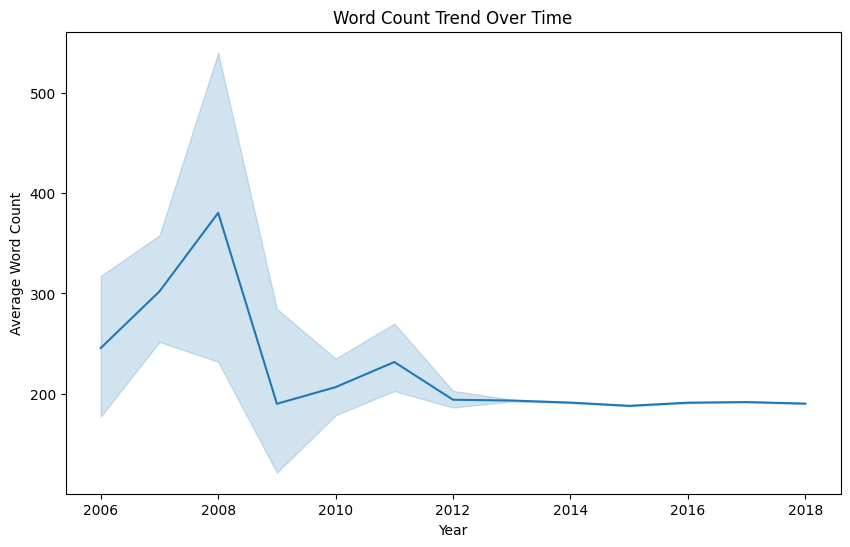

In [ ]:
# Convert timestamps to date format
item_df['created_at'] = pd.to_datetime(item_df['created_at_ts'], unit='ms')

# Analyze trends in word counts by year
item_df['year'] = item_df['created_at'].dt.year
plt.figure(figsize=(10, 6))
sns.lineplot(x='year', y='words_count', data=item_df)
plt.title('Word Count Trend Over Time')
plt.xlabel('Year')
plt.ylabel('Average Word Count')
plt.show()

3. Examine the relationship between word counts and article categories (category_id). This will visually reveal the distribution of word counts across different categories, helping to understand whether certain types of articles have more concentrated or dispersed word counts.

461


<Axes: >

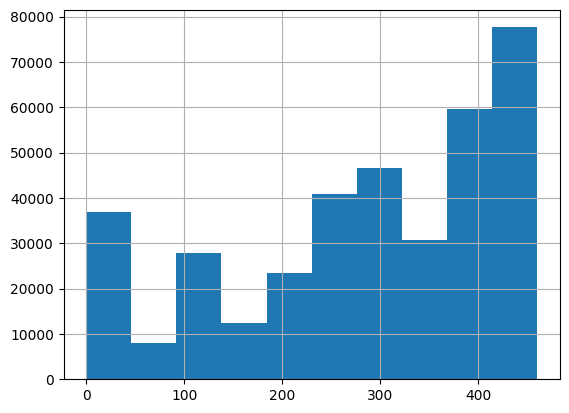

In [ ]:
print(item_df['category_id'].nunique())  # total of 461 article categories
item_df['category_id'].hist()

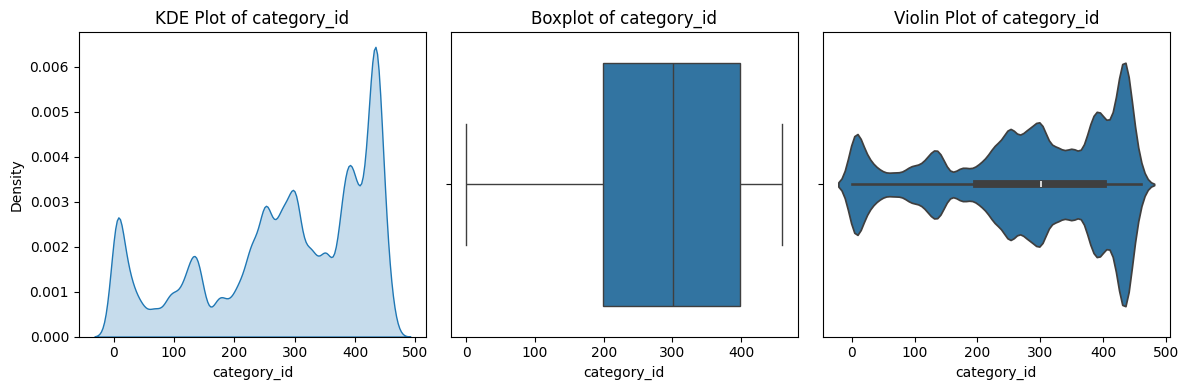

In [ ]:
#  Group by category and plot different plots to view word count distribution
plot_distribution(item_df, 'category_id')

To conclude:
These 364,047 articles have 461 categories. Average word counts for each article is concentrated around 200. The variance of word counts for each article greatly reduced over the years. For the past few years, users prefer shorter news article length.

### d. Embedding Vector Representation of News Articles

To work with news articles in a machine learning model, we need a way to represent them numerically. A common approach is to encode each article as a fixed-length embedding vector, which captures its semantic meaning.

The idea is to map the high-dimensional word index table containing words from all articles into low-dimensional vector space using pre-trained word embeddings like Word2Vec, GloVe, FastText, or BERT. These models provide vector representations for individual words, which we can then combine to represent an entire article.

Assuming we have the following two news articles:

Article A: "Scientists discover a new vaccine that can effectively prevent influenza."  
Article B: "National policies are introduced to encourage companies to increase environmental investment."

If we use, for example, a 100-dimensional word embedding model, we can compute an article embedding using one of the following methods:

1. **Average Vector**: Compute the average of the vectors of each word in the article to obtain the article's embedding vector.
2. **Weighted Average Vector**: Compute a weighted average of the vectors of each word in the article, with weights based on values like TF-IDF.
3. **Model Encoding**: Use shallow neural network or deep learning models (e.g., Word2Vec, Transformers) to encode the entire article into a fixed-length vector.

Assuming we use the average vector method, the word vectors in Article A are as follows (for simplicity, let's assume the vector dimension is 3):

- "Scientists": [0.2, 0.1, 0.5]
- "Discover": [0.3, 0.2, 0.4]
- "New": [0.1, 0.4, 0.3]
- "Vaccine": [0.5, 0.6, 0.2]
... (vectors for other words)

The embedding vector for Article A can be obtained by averaging these word vectors. This gives us a simple but effective way to represent articles in a way that models can work with.

In [ ]:
# Download the necessary NLTK data
nltk.download('punkt_tab')

# Article content
article = "This week’s White House Report Card capped an eventful week that showed inflation was still hot, a major pollster predicting President Joe Biden’s reelection defeat, and Russian President Vladimir Putin offering an unwelcome election endorsement."

# Tokenization
tokens = nltk.word_tokenize(article)

# Build a simple word embedding dictionary (randomly generated vectors)
embedding_dim = 100  # Assume the word embedding vector dimension is 100
word_embeddings = {}
for word in set(tokens):
    word_embeddings[word] = np.random.rand(embedding_dim)

# Get the embedding vector for each word
word_vectors = [word_embeddings[word] for word in tokens if word in word_embeddings]

# Calculate the embedding vector for the entire article (taking the average)
article_embedding = sum(word_vectors) / len(word_vectors)

print("Embedding vector of the article:", article_embedding)


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Embedding vector of the article: [0.48228986 0.55023457 0.54985374 0.51656845 0.47641882 0.51949128
 0.49193763 0.53501973 0.50597801 0.57156992 0.5440959  0.54162408
 0.5025671  0.52389257 0.44875087 0.46936803 0.47255497 0.51752577
 0.53709436 0.49936882 0.4931553  0.50914694 0.56161446 0.53235535
 0.48074166 0.53553898 0.49869393 0.46744052 0.550585   0.5221956
 0.41079773 0.52350626 0.52341024 0.47985182 0.47905582 0.51789169
 0.54790126 0.43168432 0.47263029 0.53639278 0.53485372 0.54004049
 0.40396364 0.41788652 0.47647032 0.54027743 0.48442799 0.41308776
 0.43427056 0.5465913  0.54496586 0.38599002 0.54179241 0.51555146
 0.44082978 0.58784307 0.48476229 0.52240315 0.41615554 0.48549164
 0.50391578 0.43734424 0.46560431 0.51644029 0.55802778 0.49575355
 0.54664573 0.58552226 0.46772078 0.58587444 0.53556465 0.5418728
 0.44681119 0.52115396 0.60362631 0.51261342 0.48025761 0.49091189
 0.46757794 0.43797488 0.5515565  0.47503716 0.48720796 0.46803417
 0.46760416 0.57326348 0.564767

In [ ]:
item_emb_df.head()

,article_id,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,...,emb_240,emb_241,emb_242,emb_243,emb_244,emb_245,emb_246,emb_247,emb_248,emb_249
0,0,-0.161183,-0.957233,-0.137944,0.050855,0.830055,0.901365,-0.335148,-0.559561,-0.500603,...,0.321248,0.313999,0.636412,0.169179,0.540524,-0.813182,0.286870,-0.231686,0.597416,0.409623
1,1,-0.523216,-0.974058,0.738608,0.155234,0.626294,0.485297,-0.715657,-0.897996,-0.359747,...,-0.487843,0.823124,0.412688,-0.338654,0.320786,0.588643,-0.594137,0.182828,0.397090,-0.834364
2,2,-0.619619,-0.972960,-0.207360,-0.128861,0.044748,-0.387535,-0.730477,-0.066126,-0.754899,...,0.454756,0.473184,0.377866,-0.863887,-0.383365,0.137721,-0.810877,-0.447580,0.805932,-0.285284
3,3,-0.740843,-0.975749,0.391698,0.641738,-0.268645,0.191745,-0.825593,-0.710591,-0.040099,...,0.271535,0.036040,0.480029,-0.763173,0.022627,0.565165,-0.910286,-0.537838,0.243541,-0.885329
4,4,-0.279052,-0.972315,0.685374,0.113056,0.238315,0.271913,-0.568816,0.341194,-0.600554,...,0.238286,0.809268,0.427521,-0.615932,-0.503697,0.614450,-0.917760,-0.424061,0.185484,-0.580292


In [ ]:
item_emb_df.shape

(364047, 251)

## Data Analysis

### 1. User Repeated Clicks

In [ ]:
# Merge train set and test A set
user_click_merge = pd.concat([train_click, test_click])

# User Repeated Clicks
user_click_count = user_click_merge.groupby(['user_id', 'click_article_id'])['click_timestamp'].agg({'count'}).reset_index()
user_click_count.head()

,user_id,click_article_id,count
0,0,30760,1
1,0,157507,1
2,1,63746,1
3,1,289197,1
4,2,36162,1


In [ ]:
user_click_count[user_click_count['count'] > 7]

,user_id,click_article_id,count
311242,86295,74254,10
311243,86295,76268,10
393761,103237,205948,10
393763,103237,235689,10
576902,134850,69463,13


In [ ]:
# User Repeated Clicks
user_click_count.loc[:, 'count'].value_counts()

,count
count,
1,1605541
2,11621
3,422
4,77
5,26
6,12
10,4
7,3
13,1


It can be observed that 1,605,541 [user, article] pair (approximately 99.2%) only interacted once, with only a very small number of users clicking on the same article multiple times. This can also be treated as a separate feature.

### 2. User Activity Level - the distribution of the number of news articles clicked by users

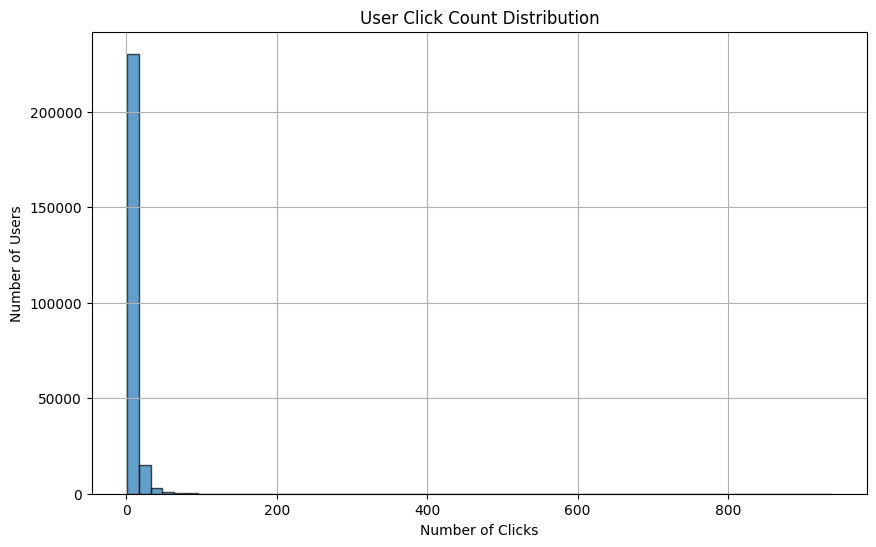

In [ ]:
# Generate click count distribution
user_click_item_count = sorted(user_click_merge.groupby(['user_id'])['click_article_id'].count(), reverse=True)

# Plot the cumulative distribution chart
plt.figure(figsize=(10, 6))
plt.hist(user_click_item_count, bins=60, edgecolor='black', alpha=0.7)
plt.title('User Click Count Distribution')
plt.xlabel('Number of Clicks')
plt.ylabel('Number of Users')
plt.grid(True)
plt.show()

High activity threshold:  9.0
Low activity threshold:  2.0


Text(0, 0.5, 'Number of Users')

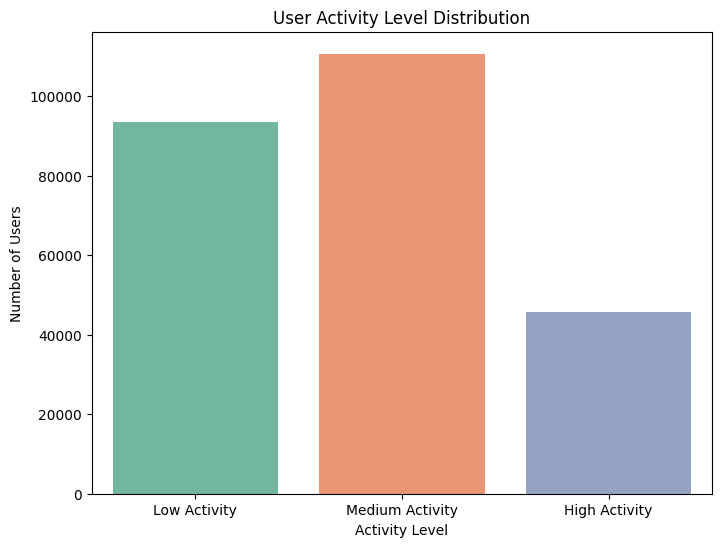

In [ ]:
user_click_item_count_series = pd.Series(user_click_item_count)

threshold_high = user_click_item_count_series.quantile(0.8)
print("High activity threshold: ", threshold_high)
threshold_low = user_click_item_count_series.quantile(0.2)
print("Low activity threshold: ", threshold_low)

user_activity_level = pd.cut(user_click_item_count_series, bins=[0, threshold_low, threshold_high, float('inf')], labels=['Low Activity', 'Medium Activity', 'High Activity'])
activity_df = pd.DataFrame({'Activity Level': user_activity_level})

# Plot the distribution of activity levels as a bar chart
plt.figure(figsize=(8, 6))
sns.countplot(data=activity_df, x='Activity Level', palette='Set2', order=['Low Activity', 'Medium Activity', 'High Activity'])

# Add title and labels
plt.title('User Activity Level Distribution')
plt.xlabel('Activity Level')
plt.ylabel('Number of Users')

In [ ]:
all(click > 100 for click in user_click_item_count[:50])

True

The top 50 users by click count all have over 100 clicks. We can define users with 100 or more clicks as active users. This is a straightforward approach to assessing user activity. For a more comprehensive evaluation, we will also consider click timestamps. Later, we will assess user activity levels based on both click counts and click times.

In [ ]:
print(f"No. of users who clicked less than three times: {(user_click_item_count_series <=2).sum()}")

No. of users who clicked less than three times: 93464


There are many users with click counts less than or equal to two, and these users can be considered inactive users.

### 3. News Click Count Analysis

In [ ]:
item_click_count = sorted(user_click_merge.groupby(['click_article_id'])['click_timestamp'].count(), reverse=True)

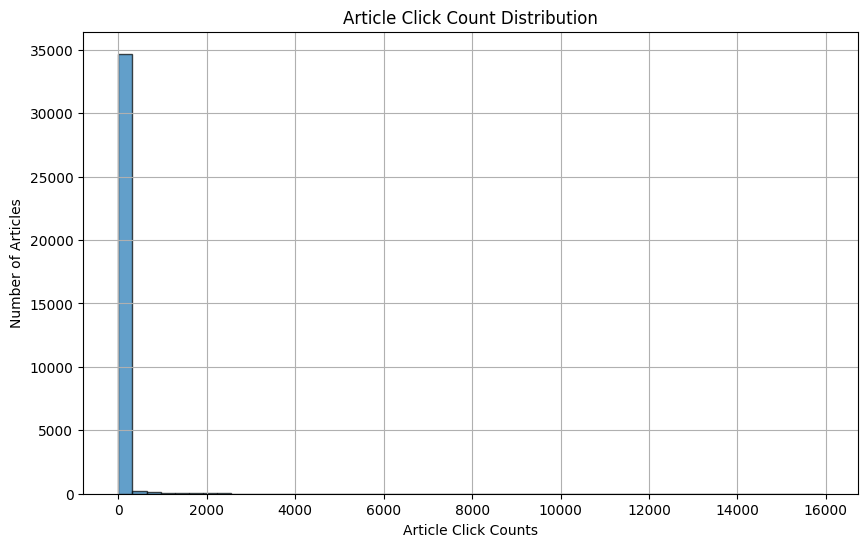

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(item_click_count, bins=50, edgecolor='black', alpha=0.7)
plt.title('Article Click Count Distribution')
plt.xlabel('Article Click Counts')
plt.ylabel('Number of Articles')
plt.grid(True)
plt.show()

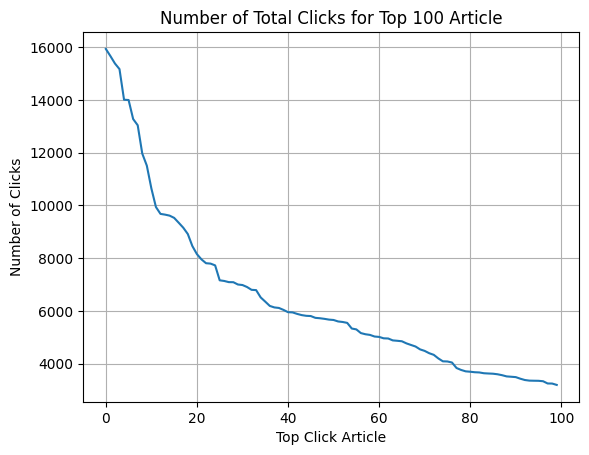

In [ ]:
plt.plot(item_click_count[:100])
plt.title('Number of Total Clicks for Top 100 Article')
plt.xlabel('Top Click Article')
plt.ylabel('Number of Clicks')
plt.grid(True)
plt.show()

It can be observed that the top 100 articles with the most clicks have click counts greater than 4000.

From the article click count analysis, we observe the following phenomena:

- A small number of articles receive very high click volumes (such as viral articles).
- Most articles have low click counts, possibly only 1 or 2 clicks (the long-tail effect).

In a conventional histogram, articles with very high click counts may "compress" those with lower counts. Logarithmic transformation can be applied to click counts to make these significantly different data points more comparable.

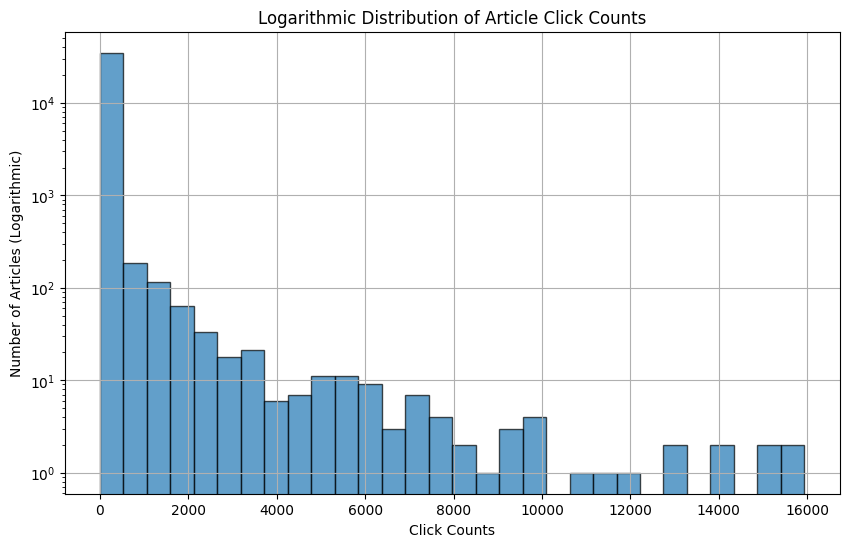

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(item_click_count, bins=30, edgecolor='black', alpha=0.7, log=True)
plt.title('Logarithmic Distribution of Article Click Counts')
plt.xlabel('Click Counts')
plt.ylabel('Number of Articles (Logarithmic)')
plt.grid(True)
plt.show()

In [ ]:
# Get the top 10 articles with the highest click counts
top_10_articles = item_click_count[:10]

print("Click counts for the top 10 articles are as follows:")
for i, count in enumerate(top_10_articles):
    print(f"Article {i} click counts: {count}")

Click counts for the top 10 articles are as follows:
Article 0 click counts: 15935
Article 1 click counts: 15666
Article 2 click counts: 15383
Article 3 click counts: 15170
Article 4 click counts: 14009
Article 5 click counts: 13998
Article 6 click counts: 13277
Article 7 click counts: 13041
Article 8 click counts: 11968
Article 9 click counts: 11511


The top 20 most-clicked articles each have over 6,000 clicks, so we can label them as popular news using this simple threshold. Popularity could also be defined more dynamically—taking into account both click counts and when the clicks occurred (timestamps).

It’s equally important to look at the other end of the spectrum: articles with very few clicks. This helps us check for a long-tail effect, where a large number of articles receive minimal engagement.

In [ ]:
# Count the number of articles with click counts less than or equal to 2
low_click_count_articles = sum(click <= 2 for click in item_click_count)
print(f"The number of articles with click counts less than or equal to 2 is: {low_click_count_articles}")

The number of articles with click counts less than or equal to 2 is: 22408


We can observe that many news articles were only clicked once or twice. These articles can be defined as "unpopular" or "niche" news.

### 4. The co-occurrence frequency of news articles

The co-occurrence frequency measures how often two articles are clicked back-to-back in a user’s browsing history.

Analyzing these patterns can uncover reading habits and preferences. For example, if two articles are frequently clicked together, it might suggest a shared theme, related content, or even a time-based connection between them.

In [ ]:
tmp = user_click_merge.sort_values('click_timestamp')
tmp['next_item'] = tmp.groupby(['user_id'])['click_article_id'].transform(lambda x: x.shift(-1))
union_item = tmp.groupby(['click_article_id', 'next_item'])['click_timestamp'].agg({'count'}).reset_index()
union_item[['count']].describe()

,count
count,433597.000000
mean,3.184139
std,18.851753
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,2202.000000


From the statistics, we can see that the average co-occurrence count is 3.18, with the highest being 2202.

This indicates that the news articles users read tend to have a relatively strong correlation.

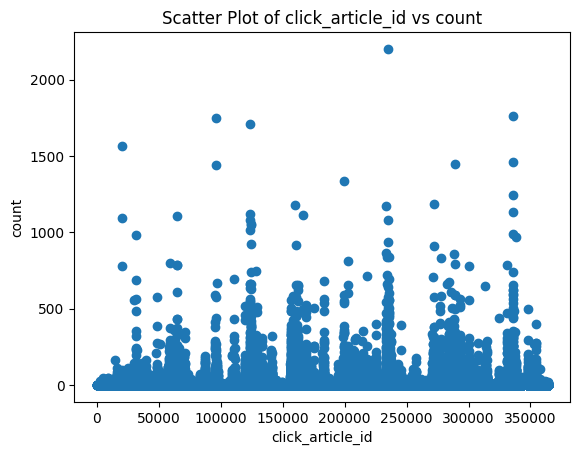

In [ ]:
# visualize the click_article_id and the count of next article clicked after this article
x = union_item['click_article_id']
y = union_item['count']
plt.scatter(x, y)
plt.xlabel('click_article_id')
plt.ylabel('count')
plt.title('Scatter Plot of click_article_id vs count')
plt.show()

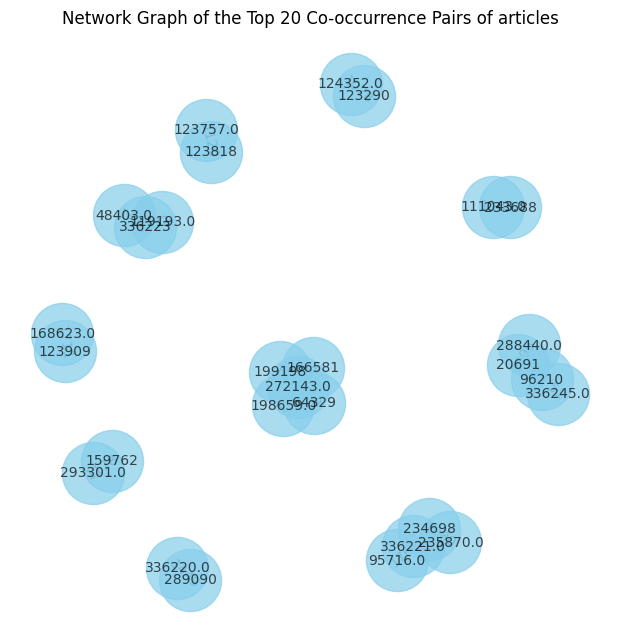

In [ ]:
# Get the top 20 co-occurrence pairs of articles
top_20_pairs = union_item.nlargest(20, 'count')

# Create the graph
G = nx.from_pandas_edgelist(top_20_pairs, 'click_article_id', 'next_item', ['count'])

# Set plot parameters
plt.figure(figsize=(6, 6))
pos = nx.spring_layout(G)  # Choose layout

# Draw nodes
nx.draw(G, pos, node_size=2000, with_labels=True, node_color='skyblue', font_size=10, font_color='black', edge_color='grey', alpha=0.7)

# Draw edges
labels = nx.get_edge_attributes(G, 'count')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

# Show the plot
plt.title('Network Graph of the Top 20 Co-occurrence Pairs of articles')
plt.show()

In [ ]:
pair_detail = item_df[item_df['click_article_id'].isin(set(top_20_pairs['click_article_id'].astype(int)) | set(top_20_pairs['next_item'].astype(int)))]
pair_detail

,click_article_id,category_id,created_at_ts,words_count,created_at,year
20691,20691,9,1507826236000,226,2017-10-12 16:37:16,2017
48403,48403,92,1507563541000,265,2017-10-09 15:39:01,2017
64329,64329,134,1506970055000,199,2017-10-02 18:47:35,2017
95716,95716,209,1507584182000,222,2017-10-09 21:23:02,2017
96210,96210,209,1507798791000,274,2017-10-12 08:59:51,2017
111043,111043,231,1507732818000,195,2017-10-11 14:40:18,2017
119193,119193,247,1507565823000,296,2017-10-09 16:17:03,2017
123290,123290,250,1507224971000,201,2017-10-05 17:36:11,2017
123757,123757,250,1507223128000,194,2017-10-05 17:05:28,2017
123818,123818,250,1507220064000,220,2017-10-05 16:14:24,2017


### 5. News Article Information

,count
category_id,
281,179455
375,152587
250,94229
412,92587
437,90056
...,...
116,1
229,1
318,1


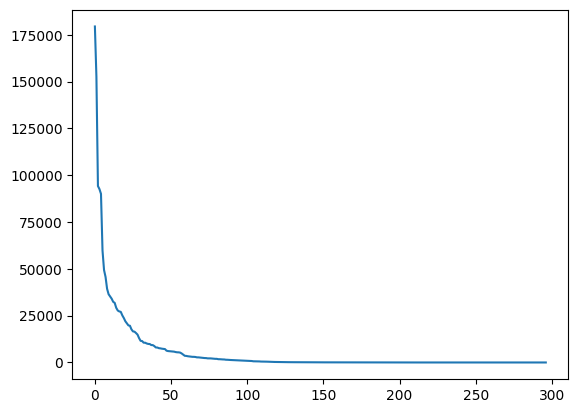

In [ ]:
# Occurrences of different categories of news that users clicked
plt.plot(user_click_merge['category_id'].value_counts().values)
user_click_merge['category_id'].value_counts()

Some news categories have only been clicked a handful of times.

In [ ]:
# Descriptive statistics of word counts of news articles that users clicked
user_click_merge['words_count'].describe()

,words_count
count,1.630633e+06
mean,2.043012e+02
std,6.382198e+01
min,0.000000e+00
25%,1.720000e+02
50%,1.970000e+02
75%,2.290000e+02
max,6.690000e+03


### 6. User Preferences for News Categories
This feature is for measuring User interest.

In [ ]:
# Get how many news categories each user clicked
user_interest_count = user_click_merge.groupby('user_id')['category_id'].nunique()
user_interest_count

,category_id
user_id,
0,2
1,2
2,2
3,2
4,2
...,...
249995,18
249996,1
249997,4


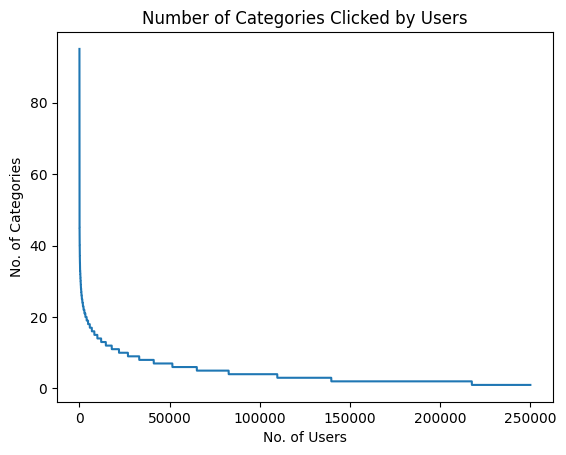

In [ ]:
plt.plot(sorted(user_click_merge.groupby('user_id')['category_id'].nunique(), reverse=True))
plt.xlabel('No. of Users')
plt.ylabel('No. of Categories')
plt.title('Number of Categories Clicked by Users')
plt.show()

From the chart above, we can see that a small portion of users have an extremely broad range of reading categories, while most people read fewer than 20 news categories.

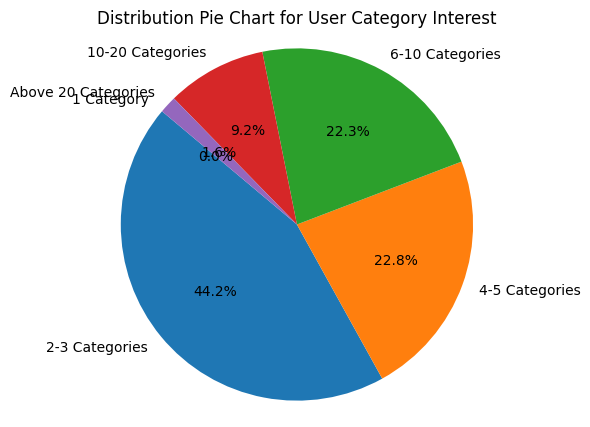

In [ ]:
interest_bins = [0, 1, 3, 5, 10, 20, float('inf')]
labels = ['1 Category', '2-3 Categories', '4-5 Categories', '6-10 Categories', '10-20 Categories', 'Above 20 Categories']
interest_categories = pd.cut(user_interest_count, bins=interest_bins, labels=labels, right=False)
plt.figure(figsize=(5, 5))
interest_distribution = interest_categories.value_counts()
plt.pie(interest_distribution, labels=interest_distribution.index, autopct='%1.1f%%', startangle=140)
plt.title("Distribution Pie Chart for User Category Interest")
plt.axis('equal')  # Keep the pie chart circular
plt.show()

### 7. Analyze the Time Interval of User Click on News articles

In [ ]:
def mean_diff_time_func(df, col):
    # Convert the timestamp to datetime format
    df[col] = pd.to_datetime(df[col], unit='ms')  # Assuming the timestamp is in milliseconds

    # Calculate the previous timestamp
    df['time_shift1'] = df[col].shift(1)

    # Calculate the time difference and convert it to minutes
    df['diff_time'] = (df[col] - df['time_shift1']).dt.total_seconds() / 60

    return df['diff_time'].mean()

# First, sort the data by user and click timestamp
user_click_merge_sorted = user_click_merge.sort_values(by=['user_id', 'click_timestamp'])

# Then, filter out users with more than 2 clicks
filtered_users = user_click_merge_sorted.groupby('user_id').filter(lambda x: len(x) > 2)

# Calculate the mean time difference between clicks for each user
mean_diff_click_time = filtered_users.groupby('user_id').apply(lambda x: mean_diff_time_func(x, 'click_timestamp'))

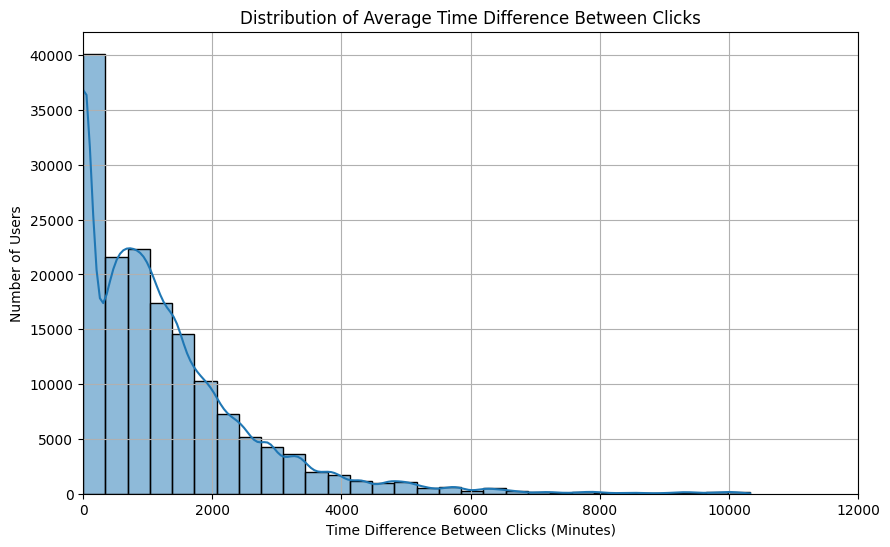

In [ ]:
mean_diff_click_time_df = mean_diff_click_time.reset_index()

# Plot the distribution graph
plt.figure(figsize=(10, 6))
sns.histplot(mean_diff_click_time_df[0], bins=30, kde=True)  # Use kde=True to overlay the kernel density estimate curve
plt.title('Distribution of Average Time Difference Between Clicks')
plt.xlabel('Time Difference Between Clicks (Minutes)')
plt.xlim(0, 12000)
plt.ylabel('Number of Users')
plt.grid()
plt.show()

The plot shows that the time intervals between article clicks vary from one user to another.

### 8. Find Similarity of News Articles Clicked by Each User Using Word2Vec

In [ ]:
#! pip install gensim  # install gensim if not installed
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import logging, pickle

def train_item_word2vec(click_df, embed_size=16, save_name='item_w2v_emb.pkl', split_char=' '):
    click_df = click_df.sort_values(by=['click_timestamp'])
    # Only string values can be used for training
    click_df['click_article_id'] = click_df['click_article_id'].astype(str)
    # Convert to sentences
    docs = click_df.groupby(['user_id'])['click_article_id'].apply(lambda x: list(x)).reset_index()
    docs = docs['click_article_id'].values.tolist()

    # Set up logging for progress visibility
    logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

    # Train the Word2Vec model
    w2v = Word2Vec(sentences=docs, vector_size=embed_size, sg=1, window=5, min_count=1, workers=24, epochs=10, seed=2020)

    # Saving the word embeddings as a dictionary
    item_w2v_emb_dict = {k: w2v.wv[k] for k in w2v.wv.index_to_key}

    return item_w2v_emb_dict, w2v

In [ ]:
item_w2v_emb_dict, w2v = train_item_word2vec(user_click_merge)

In [ ]:
# Randomly select 15 users to view the similarity of articles they've clicked on consecutively
sub_user_ids = np.random.choice(user_click_merge['user_id'].unique(), size=15, replace=False)
sub_user_info = user_click_merge[user_click_merge['user_id'].isin(sub_user_ids)]

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_count,category_id,created_at_ts,words_count
51155,182190,156560,1507056840665,4,1,17,1,21,2,12,12,281,1506957280000,185
51156,182190,156619,1507057937899,4,1,17,1,21,2,11,12,281,1507031042000,275
51157,182190,158536,1507058089631,4,1,17,1,21,1,10,12,281,1506919415000,858
51158,182190,158082,1507058151879,4,1,17,1,21,1,9,12,281,1506942774000,220
51159,182190,160146,1507058391661,4,1,17,1,21,1,8,12,281,1506965207000,249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955914,37091,331564,1507995833441,4,3,20,1,21,1,3,17,436,1507912694000,194
1023633,37091,331116,1508120878985,4,3,20,1,21,1,2,17,436,1508077619000,144
1023634,37091,206785,1508120908985,4,3,20,1,21,1,1,17,331,1508109556000,227
1109368,417,205824,1508204818986,4,3,2,1,25,2,2,2,331,1508186077000,231


In [ ]:
def get_item_sim_list(df):
    sim_list = []
    item_list = df['click_article_id'].values.tolist()
    for i in range(len(item_list) - 1):
        emb1 = item_w2v_emb_dict[str(item_list[i])]
        emb2 = item_w2v_emb_dict[str(item_list[i+1])]
        sim_list.append(np.dot(emb1, emb2)/(np.linalg.norm(emb1)*(np.linalg.norm(emb2))))
    return sim_list

In [ ]:
# Visualize the Word2Vec results
for _, user_df in sub_user_info.groupby('user_id'):
    item_sim_list = get_item_sim_list(user_df)
    print(f"User ID {user_df['user_id'].unique()[0]}: ", item_sim_list)

User ID 417:  [0.9325777]
User ID 37091:  [0.8222571, 1.0, 0.6586667, 0.97692513, 0.7162732, 0.8426666, 0.9061645, 0.62720877, 0.8338544, 0.9114524, 0.87253773, 0.9082852, 0.86150205, 0.8237552, 0.65721506, 0.8632228]
User ID 55161:  [0.8751384]
User ID 60747:  [0.8443167]
User ID 66818:  [0.95849365, 0.9108539, 0.92472214, 0.9559186, 0.9749401, 0.88189614, 0.97377217]
User ID 71495:  [0.7691211, 0.7173631]
User ID 73299:  [0.9622867, 0.8002864, 0.8605254]
User ID 75530:  [0.9898003, 0.85026014, 0.9870092]
User ID 78893:  [0.90796924, 0.97291094, 0.93422824, 0.9622867, 0.989292, 0.62153417, 0.8879897]
User ID 81107:  [0.9741483]
User ID 93735:  [0.9099224]
User ID 167647:  [0.954998]
User ID 175974:  [0.8185794, 0.41883844, 0.7231276]
User ID 181211:  [0.73779744, 0.7794456, 0.9257075, 0.8460057, 0.8851808, 0.97649366, 0.83431214, 0.94621825, 0.9109234]
User ID 182190:  [0.97985727, 0.93228704, 0.9668226, 0.90388316, 0.91122353, 0.7831215, 0.9713733, 0.9661314, 0.96591526, 0.8510091, 0

 The results show that the similarity of articles each user clicked on consecutively tend to be high.

## Summary

Through the data analysis, we've uncovered several key insights that will greatly inform our feature engineering and model development:

1. **Users are Unique**: The training and test sets have completely different users, creating a **cold-start problem**. Our model must be designed to effectively recommend content to new users with no historical data.

2. **Behavior is Sparse**: The test set shows sparser user behavior, with some users clicking only once. In contrast, the training set reveals that users often have **repetitive clicks** (>= 2 clickes) on the same articles, which can be a valuable feature to consider.

3. **Environments Vary**: A single user accesses content from different devices, countries, and sources. This **diversity in click environment** can be captured by creating features that measure things like the variety of devices used or the variance in click times.

4. **Frequency is a Feature**: We found significant variation in both the number of clicks per user and the click frequency of articles. This allows us to create features that measure **user activity levels** and **article popularity**.

5. **History is Predictive**: A user's reading choices are strongly influenced by their past behavior. By creating features that measure the **similarity between new content and a user's historical clicks**, we can improve recommendation accuracy.

6. **Preferences Exist**: Users have distinct preferences for content, including **article length and topic**. Features that reflect a user's average word count or distribution of topics can help capture these preferences.

7. **Timing Matters**: The time between a user's clicks reveals their engagement patterns. Analyzing the **time gaps between clicks** can help us better understand their behavior over time.

By leveraging these insights, we can build a more robust and effective feature set, which in turn will improve the performance of our models. This process of identifying and incorporating meaningful hidden patterns is critical for success.
